In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
import glob
from PIL import Image
import random
import numpy as np
import torchvision
from tqdm import tqdm
import os
from torch.nn import init
import cv2
import h5py
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# UNet Model

In [2]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = out_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=3),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Softmax(dim = 1)
                    )
            return  block
        
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        
        # Encode
        self.conv_encode1 = self.contracting_block(in_channels = in_channel, out_channels = 64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)
        
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 256, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1, stride = 1)
                            )
        
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2])
            upsampled = F.pad(upsampled, (int((c/2)), int((c/2)), int((c/2)), int((c/2))))
            c = bypass.shape[2] - upsampled.shape[2]
            upsampled = F.pad(upsampled, (c, 0, c, 0))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        
        return  final_layer

# UNet++ Model

In [3]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

### compute model params
def count_param(model):
    param_count = 0
    for param in model.parameters():
        param_count += param.view(-1).size()[0]
    return param_count

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size+(n_concat-2)*out_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, padding=0)
        else:
            self.up = nn.Sequential(
                 nn.UpsamplingBilinear2d(scale_factor=2),
                 nn.Conv2d(in_size, out_size, 1))
           
        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, high_feature, *low_feature):
        outputs0 = self.up(high_feature)
        for feature in low_feature:
            outputs0 = torch.cat([outputs0, feature], 1)
        return self.conv(outputs0)
    
class UNet_Nested(nn.Module):

    def __init__(self, in_channels=1, n_classes=2, feature_scale=2, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_Nested, self).__init__()
        self.in_channels = in_channels
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat01 = unetUp(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp(filters[2], filters[1], self.is_deconv, 4)
        
        self.up_concat04 = unetUp(filters[1], filters[0], self.is_deconv, 5)
        
        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)
        self.softmax = torch.nn.Softmax(dim = 1)
        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)       # 16*512*512
        maxpool0 = self.maxpool(X_00)    # 16*256*256
        X_10= self.conv10(maxpool0)      # 32*256*256
        maxpool1 = self.maxpool(X_10)    # 32*128*128
        X_20 = self.conv20(maxpool1)     # 64*128*128
        maxpool2 = self.maxpool(X_20)    # 64*64*64
        X_30 = self.conv30(maxpool2)     # 128*64*64
        maxpool3 = self.maxpool(X_30)    # 128*32*32
        X_40 = self.conv40(maxpool3)     # 256*32*32
        # column : 1
        X_01 = self.up_concat01(X_10,X_00)
        X_11 = self.up_concat11(X_20,X_10)
        X_21 = self.up_concat21(X_30,X_20)
        X_31 = self.up_concat31(X_40,X_30)
        # column : 2
        X_02 = self.up_concat02(X_11,X_00,X_01)
        X_12 = self.up_concat12(X_21,X_10,X_11)
        X_22 = self.up_concat22(X_31,X_20,X_21)
        # column : 3
        X_03 = self.up_concat03(X_12,X_00,X_01,X_02)
        X_13 = self.up_concat13(X_22,X_10,X_11,X_12)
        # column : 4
        X_04 = self.up_concat04(X_13,X_00,X_01,X_02,X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1+final_2+final_3+final_4)/4
#         final = self.softmax(final)

        if self.is_ds:
            return final
        else:
            return final_4

# Loading Dataset

In [4]:
f = h5py.File('Dataset/Brain Tumor/190.mat', 'r')
data = f['cjdata']

image = data['image']
label = data['label']
tumorBorder = data['tumorBorder']
tumorMask = data['tumorMask']

In [5]:
# fig, ax = plt.subplots(2, 2, figsize = (15, 15))
# ax[0, 0].imshow(image)
# ax[0, 1].imshow(label)
# ax[1, 0].imshow(tumorBorder)
# ax[1, 1].imshow(tumorMask)

In [6]:
# # Get the X and y 
# files = glob.glob('Dataset/Brain Tumor/*')
# X = []
# y = []
# c = 0
# for i in files:
#     c += 1
#     print(c)
#     f = h5py.File(i, 'r')
#     data = f['cjdata']

#     image = cv2.resize(np.array(data['image']), (256, 256), interpolation = cv2.INTER_NEAREST)
# #     image = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
#     label = int(np.array(data['label'])[0][0])
#     tumorMask = cv2.resize(np.array(data['tumorMask']), (256, 256), interpolation = cv2.INTER_NEAREST)
#     tumorMask = np.where(tumorMask == 1, label, tumorMask)
    
#     X.append(image)
#     y.append(tumorMask)

In [7]:
# X = np.array(X)
# y = np.array(y)

In [8]:
# n = X.shape[0]
# sample = random.sample(range(0, n), n)
# sample = np.array(sample)
# np.save('sample-tumor', sample)

In [9]:
X = np.load('X.npy')
y = np.load('y.npy')
sample = np.load('sample-tumor.npy')

In [10]:
train = sample[:2145]
val = sample[2145:2451]
test = sample[2451:]

In [11]:
# X = torch.from_numpy(X)
# mean, std = X.float().mean([1, 2]), X.float().std([1, 2])

# transform_norm = transforms.Compose([
#     transforms.Normalize(mean, std)
# ])
  
# img_normalized = transform_norm(X)
  
# X = np.array(img_normalized)

# Implementing the models

In [12]:
unet_plus = UNet_Nested(in_channels = 1, n_classes = 4)
optimizer = torch.optim.Adam(unet_plus.parameters(), lr = 1e-3)
unet_plus = nn.DataParallel(unet_plus)
unet_plus.to("cuda")

DataParallel(
  (module): UNet_Nested(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv00): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv10): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [13]:
# unet = UNet(in_channel = 1, out_channel = 4)
# optimizer = torch.optim.Adam(unet.parameters(), lr = 1e-3)
# unet = nn.DataParallel(unet)
# unet.to("cuda")

In [14]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets.float(), reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [16]:
epochs = 60
batch_size = 32
total_batches = train.shape[0] // batch_size

criterion = DiceBCELoss()
# criterion = torch.nn.CrossEntropyLoss()

history = []
dev_history = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad() 
        
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, 1, X[0].shape[0], X[0].shape[1]))
      label = np.zeros((batch_size, y[0].shape[0], y[0].shape[1]))
      for b in range(batch_size):
            inp[b] = X[train[c]]
            label[b] = y[train[c]]
            c += 1
    
            
      inp = (torch.from_numpy(inp))
      inp = inp.float().to(device)
      label = torch.from_numpy(label)
        
    
      # Generating outputs  
      outputs = unet_plus(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
      label = F.one_hot(label, num_classes = 4).permute(0, 3, 1, 2)
        
      # Calculating loss
      loss = criterion(outputs, label)
      loss.backward()
      total_loss += float(loss.item())
      optimizer.step()
        
    total_loss /= total_batches
    
    history.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, 1, X[0].shape[0], X[0].shape[1]))
        dev_label = np.zeros((batch_size, y[0].shape[0], y[0].shape[1]))
        for b in range(batch_size):
            dev_input[b][0] = X[val[c1]]
            dev_label[b] = y[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_plus(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        dev_label = F.one_hot(dev_label, num_classes = 4).permute(0, 3, 1, 2)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= total_batches
    dev_history.append(total_dev_loss * 10)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss) + ', Val Loss : ' + str(total_dev_loss * 10))


Epoch is running :: 100%|██████████| 67/67 [00:14<00:00,  5.12it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 1 / 60, Loss : 0.12076665839152549, Val Loss : 0.07967889364530792



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.05it/s]

Epoch is running ::   1%|▏         | 1/67 [00:00<00:12,  5.12it/s]

Epoch : 2 / 60, Loss : 0.0552596874090273, Val Loss : 0.07229143447840392



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.09it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 3 / 60, Loss : 0.05062301512529601, Val Loss : 0.06930168940504985



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.78it/s]

Epoch is running ::   1%|▏         | 1/67 [00:00<00:13,  5.04it/s]

Epoch : 4 / 60, Loss : 0.047017266501241654, Val Loss : 0.06270110607147217



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.05it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 5 / 60, Loss : 0.04467195361407835, Val Loss : 0.06295725202827311



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.07it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 6 / 60, Loss : 0.041864594138825116, Val Loss : 0.05764950233608929



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.98it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 7 / 60, Loss : 0.040060219785837986, Val Loss : 0.05784990794178265



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.88it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 8 / 60, Loss : 0.03507226902935932, Val Loss : 0.049956145960448395



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.05it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 9 / 60, Loss : 0.0321268241074103, Val Loss : 0.049897531019662746



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.00it/s]

Epoch is running ::   1%|▏         | 1/67 [00:00<00:13,  5.04it/s]

Epoch : 10 / 60, Loss : 0.02965659217269563, Val Loss : 0.05176917747107905



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.92it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 11 / 60, Loss : 0.02982892857781097, Val Loss : 0.043833205448602565



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.90it/s]

Epoch is running ::   1%|▏         | 1/67 [00:00<00:13,  5.06it/s]

Epoch : 12 / 60, Loss : 0.027710045423747887, Val Loss : 0.04421146975746795



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.87it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 13 / 60, Loss : 0.024102198933042697, Val Loss : 0.040426778037156635



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.01it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 14 / 60, Loss : 0.02278881319868031, Val Loss : 0.04139636184519797



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.94it/s]

Epoch is running ::   1%|▏         | 1/67 [00:00<00:12,  5.10it/s]

Epoch : 15 / 60, Loss : 0.022189276932335612, Val Loss : 0.04416264232192466



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.84it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 16 / 60, Loss : 0.02157229593774276, Val Loss : 0.04433123645052981



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.11it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 17 / 60, Loss : 0.01940724865269305, Val Loss : 0.04181376672280368



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.97it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 18 / 60, Loss : 0.019001561564518446, Val Loss : 0.04081329275200617



Epoch is running :: 100%|██████████| 67/67 [00:14<00:00,  5.00it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 19 / 60, Loss : 0.017442939344293147, Val Loss : 0.04535052258132109



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.74it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 20 / 60, Loss : 0.018146274152642757, Val Loss : 0.03951739631037214



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.04it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 21 / 60, Loss : 0.016757637401347728, Val Loss : 0.03810101675231065



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.08it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 22 / 60, Loss : 0.01649576090554248, Val Loss : 0.03982672328824427



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.94it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 23 / 60, Loss : 0.015585207727862828, Val Loss : 0.038385582503987783



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.83it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 24 / 60, Loss : 0.01513163894136895, Val Loss : 0.03934759785657499



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  5.05it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 25 / 60, Loss : 0.015417164205503998, Val Loss : 0.03807715793598944



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.97it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 26 / 60, Loss : 0.01471678762515979, Val Loss : 0.04027922568258954



Epoch is running :: 100%|██████████| 67/67 [00:13<00:00,  4.96it/s]

Epoch is running ::   0%|          | 0/67 [00:00<?, ?it/s]

Epoch : 27 / 60, Loss : 0.013794678040960831, Val Loss : 0.04025577803823485



Epoch is running ::  37%|███▋      | 25/67 [00:05<00:08,  4.97it/s]


KeyboardInterrupt: 

In [17]:
torch.save(unet_plus.module.state_dict(), 'unet_plus-tumor')

In [18]:
# Loading the model
device = torch.device("cuda")
unet = UNet(in_channel = 1, out_channel = 4)
unet.load_state_dict(torch.load('unet-tumor'))
unet.to(device)

UNet(
  (conv_encode1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), st

In [19]:
# Loading the model
device = torch.device("cuda")
unet_plus = UNet_Nested(in_channels = 1, n_classes = 4)
unet_plus.load_state_dict(torch.load('unet_plus-tumor'))
unet_plus.to(device)

UNet_Nested(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

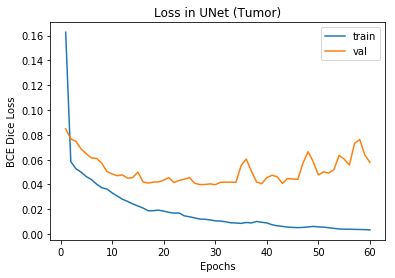

In [73]:
epoch = np.arange(1, 61)
plt.plot(epoch, history)
plt.plot(epoch, dev_history)
plt.xlabel('Epochs')
plt.ylabel('BCE Dice Loss')
plt.title('Loss in UNet (Tumor)')
plt.legend(['train', 'val'])
plt.show()

# UNet and UNet++ Results

In [32]:
k = 29
a = test[k]
inp = torch.from_numpy(X[a])
inp = torch.unsqueeze(torch.unsqueeze(inp, 0), 0).to(device)

outputs = unet(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

outputs_plus = unet_plus(inp.float())
outputs_plus = torch.argmax(outputs_plus, dim = 1).cpu()
outputs_plus = torch.squeeze(outputs_plus, 0)
output_plus = F.one_hot(outputs_plus, num_classes = 4)

label = y[a]
out = np.zeros((label.shape[0], label.shape[1], 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

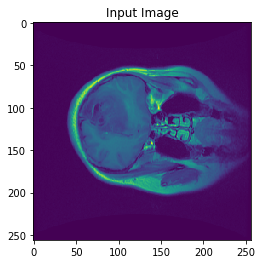

In [33]:
X_original = np.load('X_original.npy')
plt.imshow(X_original[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Background (Ground Truth)')

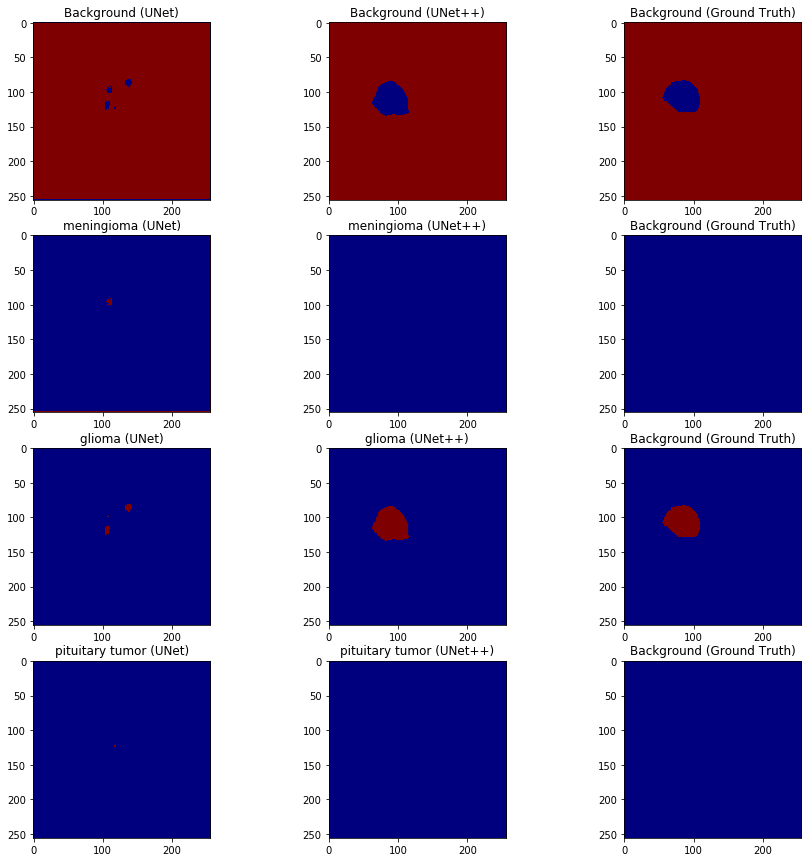

In [34]:
h, m, s, b = cv2.split(np.array(output))
h_, m_, s_, b_ = cv2.split(np.array(output_plus))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 3, figsize = (15, 15))

ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Background (UNet)')
ax[0, 1].imshow(h_, cmap = 'jet')
ax[0, 1].set_title('Background (UNet++)')
ax[0, 2].imshow(h1, cmap = 'jet')
ax[0, 2].set_title('Background (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('meningioma (UNet)')
ax[1, 1].imshow(m_, cmap = 'jet')
ax[1, 1].set_title('meningioma (UNet++)')
ax[1, 2].imshow(m1, cmap = 'jet')
ax[1, 2].set_title('Background (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('glioma (UNet)')
ax[2, 1].imshow(s_, cmap = 'jet')
ax[2, 1].set_title('glioma (UNet++)')
ax[2, 2].imshow(s1, cmap = 'jet')
ax[2, 2].set_title('Background (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('pituitary tumor (UNet)')
ax[3, 1].imshow(b_, cmap = 'jet')
ax[3, 1].set_title('pituitary tumor (UNet++)')
ax[3, 2].imshow(b1, cmap = 'jet')
ax[3, 2].set_title('Background (Ground Truth)')

# Evaluating Metrics on Test Set

In [160]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

def accuracy(outputs, target):
    outputs = F.one_hot(torch.argmax(outputs, dim = 2), num_classes = 4)
    a = np.count_nonzero(np.equal(outputs.detach().cpu(), target))
    b = outputs.shape[0] * outputs.shape[1] * outputs.shape[2]
    return (a / b) * 100

In [165]:
total_iou_score = 0
total_accuracy = 0
total_loss = 0
c = 0

for i in range(test.shape[0]):
    c += 1
    print(c)
    a = test[i]
    inp = torch.from_numpy(X[a])
    inp = torch.unsqueeze(torch.unsqueeze(inp, 0), 0).to(device)
    outputs = unet(inp.float())
    outputs = torch.squeeze(outputs, 0).permute(1, 2, 0)

    label = y[a]
    out = np.zeros((label.shape[0], label.shape[1], 4))
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i][j] == 0:
          out[i][j][0] = 1
        elif label[i][j] == 1:
          out[i][j][1] = 1
        if label[i][j] == 2:
          out[i][j][2] = 1
        if label[i][j] == 3:
          out[i][j][3] = 1

    total_iou_score += iou_score(outputs, out)
    total_accuracy += accuracy(outputs, out)
    total_loss += criterion(outputs.to(device), torch.from_numpy(out).to(device)).item()
    
total_iou_score /= 613
total_accuracy /= 613
total_loss /= 613

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [167]:
total_iou_score_plus = 0
total_accuracy_plus = 0
total_loss_plus = 0
c = 0

for i in range(test.shape[0]):
    c += 1
    print(c)
    a = test[i]
    inp = torch.from_numpy(X[a])
    inp = torch.unsqueeze(torch.unsqueeze(inp, 0), 0).to(device)
    outputs = unet_plus(inp.float())
    outputs = torch.squeeze(outputs, 0).permute(1, 2, 0)

    label = y[a]
    out = np.zeros((label.shape[0], label.shape[1], 4))
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i][j] == 0:
          out[i][j][0] = 1
        elif label[i][j] == 1:
          out[i][j][1] = 1
        if label[i][j] == 2:
          out[i][j][2] = 1
        if label[i][j] == 3:
          out[i][j][3] = 1

    total_iou_score_plus += iou_score(outputs, out)
    total_accuracy_plus += accuracy(outputs, out)
    total_loss_plus += criterion(outputs.to(device), torch.from_numpy(out).to(device)).item()
    
total_iou_score_plus /= 613
total_accuracy_plus /= 613
total_loss_plus /= 613

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [168]:
print('IoU score : ' + str(total_iou_score) + ', Accuracy : ' + str(total_accuracy) + ', BCE Dice Loss : ' + str(total_loss))

IoU score : 0.24894643383260742, Accuracy : 98.99167034404313, BCE Dice Loss : 1.1582583084270415


In [169]:
print('IoU score : ' + str(total_iou_score_plus) + ', Accuracy : ' + str(total_accuracy_plus) + ', BCE Dice Loss : ' + str(total_loss_plus))

IoU score : 0.9820455754738322, Accuracy : 99.54094070011406, BCE Dice Loss : 0.042115740478604516
